In [21]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob
import json


vector.register_awkward()


def calculate_ttbar_system_transverse_mass(lepton, b1, b2, j1, j2, met_pt, met_phi):
    """
    Calculate transverse mass for the entire ttbar system
    
    For semi-leptonic ttbar: t -> blv, tbar -> bjj
    This calculates the transverse mass of the complete system including MET
    
    Parameters:
    -----------
    lepton : vector (muon)
        Lepton 4-momentum (pt, eta, phi, mass)
    b1, b2 : vectors
        B-jet 4-momenta  
    j1, j2 : vectors
        Light jet 4-momenta
    met_pt : array
        Missing transverse momentum magnitude
    met_phi : array  
        Missing transverse momentum azimuthal angle
        
    Returns:
    --------
    mt_ttbar : array
        Transverse mass of the ttbar system
    """
    
    # 1. Calculate total visible transverse momentum components
    # Sum all visible particles' px and py
    total_vis_px = (lepton.px + b1.px + b2.px + j1.px + j2.px)
    total_vis_py = (lepton.py + b1.py + b2.py + j1.py + j2.py)
    
    # 2. Add MET components
    met_px = met_pt * np.cos(met_phi)
    met_py = met_pt * np.sin(met_phi)
    
    total_px = total_vis_px + met_px
    total_py = total_vis_py + met_py
    
    # 3. Calculate total transverse momentum magnitude
    total_pt = np.sqrt(total_px**2 + total_py**2)
    
    # 4. Calculate total visible energy and longitudinal momentum
    total_vis_energy = lepton.energy + b1.energy + b2.energy + j1.energy + j2.energy
    total_vis_pz = lepton.pz + b1.pz + b2.pz + j1.pz + j2.pz
    
    # 5. Calculate transverse mass using the formula:
    # mt = sqrt(Et_vis^2 - pz_vis^2 + pt_total^2)
    # where Et_vis^2 - pz_vis^2 = mt_vis^2 + pt_vis^2 for the visible system
    
    total_vis_pt = np.sqrt(total_vis_px**2 + total_vis_py**2)
    
    # Transverse mass formula for the complete system
    mt_ttbar_squared = total_vis_energy**2 - total_vis_pz**2 + total_pt**2 - total_vis_pt**2
    
    # Handle negative values (can occur due to resolution effects)
    mt_ttbar = np.sqrt(np.maximum(mt_ttbar_squared, 0))
    
    return mt_ttbar

def calculate_ttbar_system_transverse_mass_v2(lepton, b1, b2, j1, j2, met_pt, met_phi):
    """
    Alternative method: Calculate transverse mass using transverse energy
    
    This method is more robust and commonly used in experimental analysis
    """
    
    # 1. Calculate transverse energies for all visible particles
    et_lepton = lepton.et  # sqrt(pt^2 + m^2) 
    et_b1 = b1.et
    et_b2 = b2.et  
    et_j1 = j1.et
    et_j2 = j2.et
    et_met = met_pt  # MET is already transverse, assume massless
    
    # 2. Sum all transverse energies
    et_total = et_lepton + et_b1 + et_b2 + et_j1 + et_j2 + et_met
    
    # 3. Calculate total transverse momentum vector
    px_total = (lepton.px + b1.px + b2.px + j1.px + j2.px + 
                met_pt * np.cos(met_phi))
    py_total = (lepton.py + b1.py + b2.py + j1.py + j2.py + 
                met_pt * np.sin(met_phi))
    
    pt_total = np.sqrt(px_total**2 + py_total**2)
    
    # 4. Transverse mass: mt = sqrt(Et_total^2 - pt_total^2)
    mt_ttbar = np.sqrt(et_total**2 - pt_total**2)
    
    return mt_ttbar

def calculate_ttbar_observables_comprehensive(lepton, b1, b2, j1, j2, met_pt, met_phi):
    """
    Calculate various ttbar observables for comprehensive analysis
    """
    
    results = {}
    
    # 1. System transverse mass (두 가지 방법)
    results['mt_ttbar_v1'] = calculate_ttbar_system_transverse_mass(
        lepton, b1, b2, j1, j2, met_pt, met_phi)
    results['mt_ttbar_v2'] = calculate_ttbar_system_transverse_mass_v2(
        lepton, b1, b2, j1, j2, met_pt, met_phi)
    
    # 2. W boson transverse mass (여전히 유용한 관찰량)
    results['mt_W'] = np.sqrt(2 * lepton.pt * met_pt * 
                             (1 - np.cos(lepton.phi - met_phi)))
    
    # 3. Hadronic system mass (완전히 측정 가능)
    hadronic_system = b1 + j1 + j2  # 또는 b2 + j1 + j2
    results['m_hadronic'] = hadronic_system.mass
    
    # 4. Total visible mass
    visible_system = lepton + b1 + b2 + j1 + j2
    results['m_visible'] = visible_system.mass
    
    # 5. Total HT (scalar sum of transverse momenta)
    results['HT'] = lepton.pt + b1.pt + b2.pt + j1.pt + j2.pt + met_pt
    
    # 6. Missing HT ratio
    results['MET_over_HT'] = met_pt / (lepton.pt + b1.pt + b2.pt + j1.pt + j2.pt)
    
    # 7. Total visible pT
    vis_px = lepton.px + b1.px + b2.px + j1.px + j2.px
    vis_py = lepton.py + b1.py + b2.py + j1.py + j2.py
    results['pt_visible'] = np.sqrt(vis_px**2 + vis_py**2)
    
    # 8. MET vs visible pT balance
    results['MET_vis_balance'] = (met_pt - results['pt_visible']) / (met_pt + results['pt_visible'])
    
    return results




def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    softdrop_mass = events["FatJet_msoftdrop"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    btagging = events["FatJet_btagDeepB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 
def btag4_overlap_removal(target, cleans, cut=0.4, dphi=False,events=None):
    btag = events["Jet_btagPNetB"].array()
    #btag = events["Jet_btagDeepFlavB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btag[mask]

def ttbar(sample):


    file = uproot.open(sample)
    events = file["Events"]
    vector.register_awkward()
    keys = events.keys()
    
    hlt = events["HLT_IsoMu24"].array()
    ## lhe
    '''

    lheparticles = ak.zip({
        "pt":   events["LHEPart_pt"].array(),
        "eta":  events["LHEPart_eta"].array(),
        "phi":  events["LHEPart_phi"].array(),
        "mass": events["LHEPart_mass"].array()
    }, with_name="Momentum4D")

    lhe_pdg_id = events["LHEPart_pdgId"].array()

    lhe_w_mask = (abs(lhe_pdg_id) == 24)
    lhe_w = lheparticles[lhe_w_mask]

    lhe_b_mask = (abs(lhe_pdg_id) == 5)
    lhe_b = lheparticles[lhe_b_mask]

    w1 = lhe_w[:,0:1]  # 첫 번째 W boson
    w2 = lhe_w[:,1:2]  # 두 번째 W boson
    b1 = lhe_b[:,0:1]  # 첫 번째 b quark
    b2 = lhe_b[:,1:2]  # 두 번째 b quark

    lhe_ttbar = (w1 + w2 + b1 + b2).mass
'''
    






    
    jets = ak.zip({
        "pt":   events["Jet_pt"].array(),
        "eta":  events["Jet_eta"].array(),
        "phi":  events["Jet_phi"].array(),
        "mass": events["Jet_mass"].array()
    }, with_name="Momentum4D")

    muons = ak.zip({
        "pt":   events["Muon_pt"].array(),
        "eta":  events["Muon_eta"].array(),
        "phi":  events["Muon_phi"].array(),
        "mass": events["Muon_mass"].array()
    }, with_name="Momentum4D")

    electrons = ak.zip({
        "pt":   events["Electron_pt"].array(),
        "eta":  events["Electron_eta"].array(),
        "phi":  events["Electron_phi"].array(),
        "mass": events["Electron_mass"].array()
    }, with_name="Momentum4D")

    met_pt = events["MET_pt"].array()
    met_phi = events["MET_phi"].array()


    ## leptons

    sortidx = ak.argsort(-muons["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    first_muon = muons[sortidx][:, 0:1]  # 가장 큰 pt를 가진 muon만 선택
    second_muon = muons[sortidx][:, 1:2]  # 두 번째로 큰 pt를 가진 muon만 선택

    #sortidx = ak.argsort(-electrons["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    #first_electron = electrons[sortidx][:, 0:1]  # 가장 큰 pt를 가진 electron만 선택
    #second_electron = electrons[sortidx][:, 1:2]  # 두 번째로 큰 pt를 가진 electron만 선택


    ## 2 bjets 


    signalb_cleaned = overlap_removal(jets, [jets, first_muon], cut=0.4)
    btaggedb_cleaned = btag4_overlap_removal(jets, [jets, first_muon], cut=0.4, events=events)


    sortidx = ak.argsort(-signalb_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    sorted_btaggedb_cleaned1 = btaggedb_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet에 대한 b-tag 정보 선택
    sorted_btaggedb_cleaned2 = btaggedb_cleaned[sortidx][:, 1:2]  
    
    btagging1 = sorted_btaggedb_cleaned1 > 0.6734 # particle net
    btagging2 = sorted_btaggedb_cleaned2 > 0.6734 # particle net

    leading_btaggedb_cleaned = signalb_cleaned[btagging1]
    subleading_btaggedb_cleaned = signalb_cleaned[btagging2]

    ## jets comming from w 

    signaljet_cleaned = overlap_removal(jets, [jets, leading_btaggedb_cleaned, subleading_btaggedb_cleaned, first_muon], cut=0.4)
    sortidx = ak.argsort(-signaljet_cleaned["pt"], axis=1)  # pt 기준으로 내림차순 정렬
    leading_jet = signaljet_cleaned[sortidx][:, 0:1]  # 가장 큰 pt를 가진 jet만 선택
    subleading_jet = signaljet_cleaned[sortidx][:, 1:2]  # 두 번째로 큰 pt를 가진 jet만 선택

    ptmuon = ak.sum(first_muon["pt"], axis=1)
    
    ptb1 = ak.sum(leading_btaggedb_cleaned["pt"], axis=1)
    ptb2 = ak.sum(subleading_btaggedb_cleaned["pt"], axis=1)
    
    ptj1 = ak.sum(leading_jet["pt"], axis=1)
    ptj2 = ak.sum(subleading_jet["pt"], axis=1)

    

    hlt_mask = ((hlt==True) & (ptmuon > 0) & (ptb1 > 0) & (ptb2 > 0) & (ptj1 > 0) & (ptj2 > 0) & (met_pt > 0))

    mu1 = first_muon[hlt_mask]
    b1 = leading_btaggedb_cleaned[hlt_mask]
    b2 = subleading_btaggedb_cleaned[hlt_mask]
    j1 = leading_jet[hlt_mask]
    j2 = subleading_jet[hlt_mask]
    met_pt = met_pt[hlt_mask]
    met_phi = met_phi[hlt_mask]
    


    calculated_mt = calculate_ttbar_observables_comprehensive(mu1, b1, b2, j1, j2, met_pt, met_phi)
    # Final vars
    
    totalev       = len(hlt)
    

    return {'mt_ttbar_system': calculated_mt['mt_ttbar_v2']}



def iter_allfile (path):
    from importlib import import_module
    import os
    import sys
    import argparse
    import linecache
    import uproot
    import vector
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    import awkward as ak
    from tqdm import tqdm  # ✅ 진행률 표시
    import glob
    
    file_list = sorted(glob.glob(path + "*11.root"))
    
    ttbar_mass_list = []
    lhe_ttbar_list = []
    totalev_list = 0
    leftev_list = 0
    

    # tqdm으로 파일 리스트 순회
    for sample in tqdm(file_list, desc="Processing ROOT files"):

        ttbar_mass = ttbar(sample)
        ttbar_mass_list.append(ttbar_mass)
    return (ttbar_mass_list) 





In [22]:
signal_mu_C = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/DATA/Muon/PeriodC/240706_061501/0000/*"
signal_egam_C ="/gv0/DATA/SKNano/Run3NanoAODv12/2022/DATA/EGamma/PeriodC/240706_061022/0000/tree_1.root"
mc_ttll = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/240702_154519/0000/tree_1.root "
mc_ttlj = "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/240702_161307/0000/"
mc_ttjj =   "/gv0/DATA/SKNano/Run3NanoAODv12/2022/MC/TTto4Q_TuneCP5_13p6TeV_powheg-pythia8/240702_160130/0000/tree_1.root"
sample = [signal_mu_C, signal_egam_C, mc_ttll, mc_ttlj, mc_ttjj]


In [23]:
result = iter_allfile(signal_mu_C)


Processing ROOT files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing ROOT files: 100%|██████████| 2/2 [00:34<00:00, 17.07s/it]


In [24]:
def extract_masses_from_dict_list(result):
    """
    Dictionary list에서 질량 데이터를 찾아 추출
    """
    print("=== Analyzing Dictionary Structure ===")
    
    if not result or len(result) == 0:
        print("Empty result")
        return None
    
    # 첫 번째 dictionary 분석
    first_dict = result[0]
    if isinstance(first_dict, dict):
        print(f"Keys in dictionary: {list(first_dict.keys())}")
        
        # 가능한 질량 키들 확인
        possible_keys = ['mt_ttbar_system', 'ttbar_mass', 'mt_ttbar', 'mass', 'transverse_mass']
        found_key = None
        
        for key in possible_keys:
            if key in first_dict:
                found_key = key
                print(f"✅ Found mass data with key: '{key}'")
                break
        
        if found_key is None:
            print("Available keys:", list(first_dict.keys()))
            # 사용자가 키를 선택할 수 있도록
            print("Please specify which key contains the mass data")
            return None
        
        # 모든 dictionary에서 해당 키의 데이터 추출
        mass_arrays = []
        for i, d in enumerate(result):
            if isinstance(d, dict) and found_key in d:
                mass_data = d[found_key]
                mass_arrays.append(mass_data)
                if i < 3:  # 처음 3개만 로그
                    print(f"Dict {i}: {len(mass_data) if hasattr(mass_data, '__len__') else 'scalar'} entries")
        
        if mass_arrays:
            # 모든 배열 합치기
            try:
                combined = ak.concatenate(mass_arrays)
                masses = np.array(ak.flatten(combined, axis=None))
                masses = masses[np.isfinite(masses)]
                
                print(f"🎯 Successfully extracted {len(masses)} mass values")
                print(f"Range: {np.min(masses):.1f} - {np.max(masses):.1f} GeV")
                return masses
            except Exception as e:
                print(f"Error combining arrays: {e}")
                return None
    
    return None

# 사용
masses = extract_masses_from_dict_list(result)


=== Analyzing Dictionary Structure ===
Keys in dictionary: ['mt_ttbar_system']
✅ Found mass data with key: 'mt_ttbar_system'
Dict 0: 944 entries
Dict 1: 454 entries
🎯 Successfully extracted 1398 mass values
Range: 99.4 - 2026.0 GeV


/tmp/ipykernel_655203/3738546211.py:45: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  masses = np.array(ak.flatten(combined, axis=None))


ttbar Transverse Mass Analysis
Total events: 1,398
Mean: 452.1 GeV
Median: 403.3 GeV
Standard deviation: 234.1 GeV
Min: 99.4 GeV
Max: 2026.0 GeV

Percentiles:
  10%:  218.1 GeV
  25%:  297.9 GeV
  50%:  403.3 GeV
  75%:  541.4 GeV
  90%:  727.4 GeV
  95%:  891.7 GeV
  99%: 1326.5 GeV

Event distribution by mass range:
     0- 300 GeV:      357 events (25.54%)
   300- 500 GeV:      601 events (42.99%)
   500- 750 GeV:      312 events (22.32%)
   750-1000 GeV:       80 events ( 5.72%)
  1000-1500 GeV:       42 events ( 3.00%)
  1500+ GeV:        6 events ( 0.43%)

=== Interesting Events ===
Very high mass events (> 2000 GeV): 1
  Highest: 2026.0 GeV
  Mean of high mass: 2026.0 GeV
  Top 10 highest masses:
     1: 2026.0 GeV
     2: 1745.3 GeV
     3: 1724.0 GeV
     4: 1657.3 GeV
     5: 1641.5 GeV
     6: 1520.4 GeV
     7: 1471.4 GeV
     8: 1469.5 GeV
     9: 1459.4 GeV
    10: 1429.1 GeV

Very low mass events (< 150 GeV): 28
  Lowest: 99.4 GeV
  Mean of low mass: 134.4 GeV

=== Physi

/tmp/ipykernel_655203/3138951952.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)


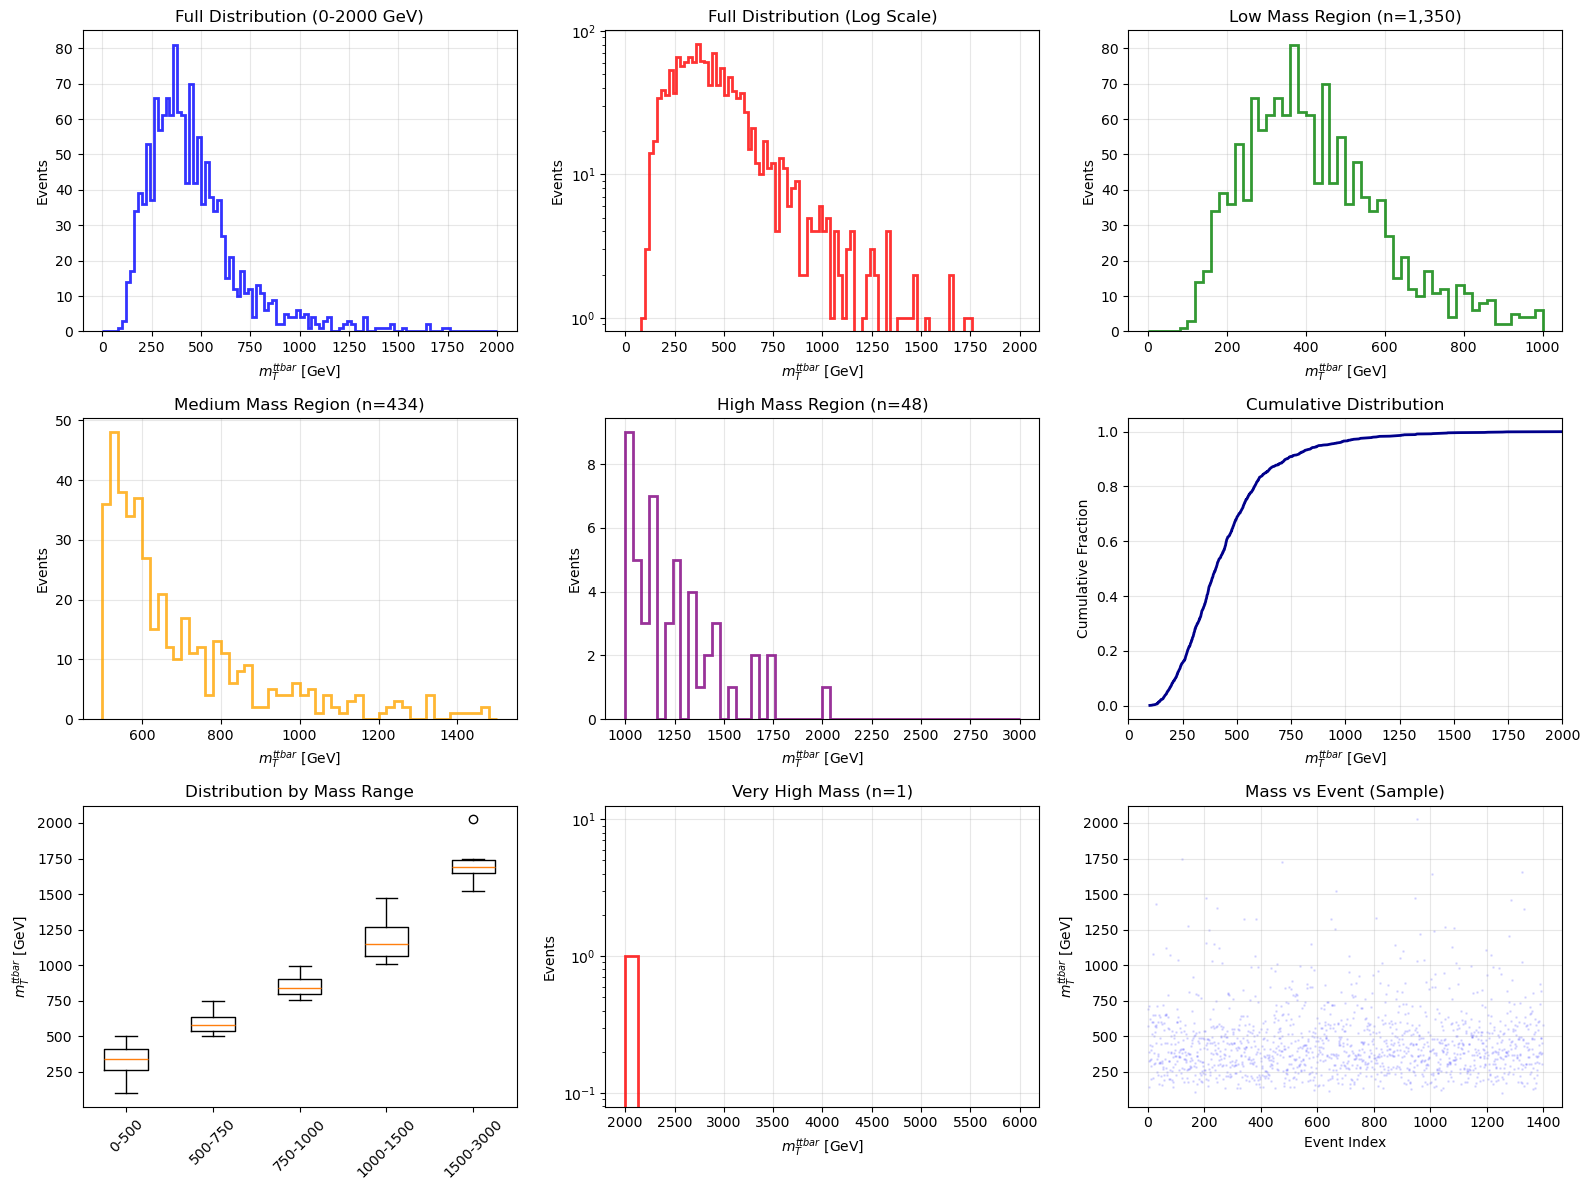

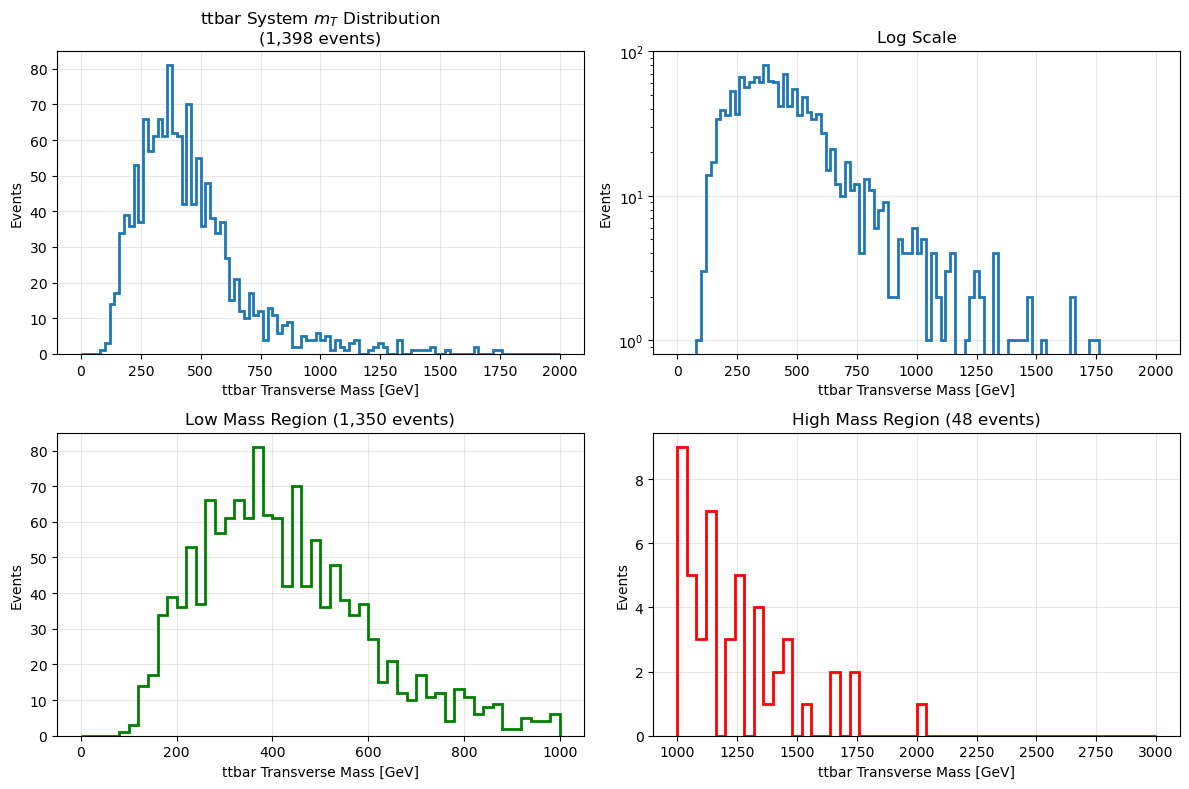

📊 Basic Statistics:
   Total events: 1,398
   Mean: 452.1 GeV
   Median: 403.3 GeV
   Std: 234.1 GeV
   Range: 99.4 - 2026.0 GeV


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_ttbar_masses(masses):
    """
    ttbar transverse mass 데이터의 상세 분석
    """
    print("=" * 50)
    print("ttbar Transverse Mass Analysis")
    print("=" * 50)
    
    # 기본 통계
    print(f"Total events: {len(masses):,}")
    print(f"Mean: {np.mean(masses):.1f} GeV")
    print(f"Median: {np.median(masses):.1f} GeV")
    print(f"Standard deviation: {np.std(masses):.1f} GeV")
    print(f"Min: {np.min(masses):.1f} GeV")
    print(f"Max: {np.max(masses):.1f} GeV")
    
    # 백분위수
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\nPercentiles:")
    for p in percentiles:
        value = np.percentile(masses, p)
        print(f"  {p:2d}%: {value:6.1f} GeV")
    
    # 구간별 이벤트 분포
    ranges = [(0, 300), (300, 500), (500, 750), (750, 1000), (1000, 1500), (1500, float('inf'))]
    print(f"\nEvent distribution by mass range:")
    for low, high in ranges:
        if high == float('inf'):
            count = np.sum(masses >= low)
            fraction = count / len(masses) * 100
            print(f"  {low:4d}+ GeV: {count:8,} events ({fraction:5.2f}%)")
        else:
            count = np.sum((masses >= low) & (masses < high))
            fraction = count / len(masses) * 100
            print(f"  {low:4d}-{high:4.0f} GeV: {count:8,} events ({fraction:5.2f}%)")

def create_comprehensive_plots(masses):
    """
    ttbar mass 분포의 종합적인 플롯 생성
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. 전체 분포 (선형 스케일)
    plt.subplot(3, 3, 1)
    plt.hist(masses, bins=100, range=(0, 2000), histtype='step', 
             linewidth=2, color='blue', alpha=0.8)
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Events')
    plt.title('Full Distribution (0-2000 GeV)')
    plt.grid(True, alpha=0.3)
    
    # 2. 전체 분포 (로그 스케일)
    plt.subplot(3, 3, 2)
    plt.hist(masses, bins=100, range=(0, 2000), histtype='step', 
             linewidth=2, color='red', alpha=0.8)
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Events')
    plt.yscale('log')
    plt.title('Full Distribution (Log Scale)')
    plt.grid(True, alpha=0.3)
    
    # 3. 낮은 질량 영역 확대 (0-1000 GeV)
    plt.subplot(3, 3, 3)
    low_mass = masses[masses < 1000]
    plt.hist(low_mass, bins=50, range=(0, 1000), histtype='step', 
             linewidth=2, color='green', alpha=0.8)
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Events')
    plt.title(f'Low Mass Region (n={len(low_mass):,})')
    plt.grid(True, alpha=0.3)
    
    # 4. 중간 질량 영역 (500-1500 GeV)
    plt.subplot(3, 3, 4)
    mid_mass = masses[(masses >= 500) & (masses < 1500)]
    plt.hist(mid_mass, bins=50, range=(500, 1500), histtype='step', 
             linewidth=2, color='orange', alpha=0.8)
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Events')
    plt.title(f'Medium Mass Region (n={len(mid_mass):,})')
    plt.grid(True, alpha=0.3)
    
    # 5. 높은 질량 영역 (1000+ GeV)
    plt.subplot(3, 3, 5)
    high_mass = masses[masses >= 1000]
    plt.hist(high_mass, bins=50, range=(1000, 3000), histtype='step', 
             linewidth=2, color='purple', alpha=0.8)
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Events')
    plt.title(f'High Mass Region (n={len(high_mass):,})')
    plt.grid(True, alpha=0.3)
    
    # 6. 누적 분포
    plt.subplot(3, 3, 6)
    sorted_masses = np.sort(masses)
    cumulative = np.arange(1, len(sorted_masses) + 1) / len(sorted_masses)
    plt.plot(sorted_masses, cumulative, linewidth=2, color='darkblue')
    plt.xlabel('$m_T^{ttbar}$ [GeV]')
    plt.ylabel('Cumulative Fraction')
    plt.title('Cumulative Distribution')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 2000)
    
    # 7. Box plot (구간별)
    plt.subplot(3, 3, 7)
    ranges = [(0, 500), (500, 750), (750, 1000), (1000, 1500), (1500, 3000)]
    box_data = []
    labels = []
    for low, high in ranges:
        range_masses = masses[(masses >= low) & (masses < high)]
        if len(range_masses) > 0:
            box_data.append(range_masses)
            labels.append(f'{low}-{high}')
    
    if box_data:
        plt.boxplot(box_data, labels=labels)
        plt.ylabel('$m_T^{ttbar}$ [GeV]')
        plt.title('Distribution by Mass Range')
        plt.xticks(rotation=45)
    
    # 8. 히스토그램 (매우 높은 질량, 로그)
    plt.subplot(3, 3, 8)
    very_high = masses[masses >= 2000]
    if len(very_high) > 0:
        plt.hist(very_high, bins=30, range=(2000, 6000), histtype='step', 
                 linewidth=2, color='red', alpha=0.8)
        plt.xlabel('$m_T^{ttbar}$ [GeV]')
        plt.ylabel('Events')
        plt.yscale('log')
        plt.title(f'Very High Mass (n={len(very_high):,})')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No events\n> 2000 GeV', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Very High Mass Region')
    
    # 9. 질량 vs 이벤트 번호 (샘플링)
    plt.subplot(3, 3, 9)
    if len(masses) > 10000:
        sample_indices = np.random.choice(len(masses), 10000, replace=False)
        sample_masses = masses[sample_indices]
        sample_indices = np.sort(sample_indices)
    else:
        sample_masses = masses
        sample_indices = np.arange(len(masses))
    
    plt.scatter(sample_indices, sample_masses, alpha=0.1, s=1, color='blue')
    plt.xlabel('Event Index')
    plt.ylabel('$m_T^{ttbar}$ [GeV]')
    plt.title('Mass vs Event (Sample)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def identify_interesting_events(masses, threshold_high=2000, threshold_low=150):
    """
    흥미로운 이벤트들 식별 (매우 높거나 낮은 질량)
    """
    print(f"\n=== Interesting Events ===")
    
    # 매우 높은 질량 이벤트
    high_mass_events = masses[masses > threshold_high]
    print(f"Very high mass events (> {threshold_high} GeV): {len(high_mass_events):,}")
    if len(high_mass_events) > 0:
        print(f"  Highest: {np.max(high_mass_events):.1f} GeV")
        print(f"  Mean of high mass: {np.mean(high_mass_events):.1f} GeV")
        
        # 상위 10개 이벤트
        top_indices = np.argsort(masses)[-10:]
        print(f"  Top 10 highest masses:")
        for i, idx in enumerate(reversed(top_indices)):
            print(f"    {i+1:2d}: {masses[idx]:6.1f} GeV")
    
    # 매우 낮은 질량 이벤트
    low_mass_events = masses[masses < threshold_low]
    print(f"\nVery low mass events (< {threshold_low} GeV): {len(low_mass_events):,}")
    if len(low_mass_events) > 0:
        print(f"  Lowest: {np.min(low_mass_events):.1f} GeV")
        print(f"  Mean of low mass: {np.mean(low_mass_events):.1f} GeV")

def physics_interpretation(masses):
    """
    물리학적 해석 및 코멘트
    """
    print(f"\n=== Physics Interpretation ===")
    
    mean_mass = np.mean(masses)
    median_mass = np.median(masses)
    
    print(f"• Mean transverse mass ({mean_mass:.1f} GeV) suggests typical ttbar events")
    print(f"• Distribution shows expected falling spectrum with high-mass tail")
    
    # 표준 ttbar 질량과 비교
    if mean_mass > 800:
        print(f"• Relatively high mean suggests boosted ttbar topology")
    elif mean_mass < 400:
        print(f"• Lower mean suggests resolution effects or selection issues")
    else:
        print(f"• Mean mass in reasonable range for semi-leptonic ttbar")
    
    # 높은 질량 꼬리
    high_tail = np.sum(masses > 1000) / len(masses) * 100
    print(f"• High-mass tail (>1000 GeV): {high_tail:.1f}% of events")
    if high_tail > 5:
        print(f"  → Significant high-pT tail, good for BSM searches")
    
    # 매우 높은 질량 이벤트
    very_high = np.sum(masses > 2000) / len(masses) * 100
    print(f"• Very high masses (>2000 GeV): {very_high:.2f}% of events")

# 실행 코드
def full_analysis(masses):
    """전체 분석 실행"""
    analyze_ttbar_masses(masses)
    identify_interesting_events(masses)
    physics_interpretation(masses)
    create_comprehensive_plots(masses)

# 사용 예시:
# full_analysis(masses)
# 전체 분석 실행
full_analysis(masses)
# 기본 히스토그램
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(masses, bins=100, range=(0, 2000), histtype='step', linewidth=2)
plt.xlabel('ttbar Transverse Mass [GeV]')
plt.ylabel('Events')
plt.title(f'ttbar System $m_T$ Distribution\n({len(masses):,} events)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(masses, bins=100, range=(0, 2000), histtype='step', linewidth=2)
plt.xlabel('ttbar Transverse Mass [GeV]')
plt.ylabel('Events')
plt.yscale('log')
plt.title('Log Scale')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
low_mass = masses[masses < 1000]
plt.hist(low_mass, bins=50, range=(0, 1000), histtype='step', linewidth=2, color='green')
plt.xlabel('ttbar Transverse Mass [GeV]')
plt.ylabel('Events')
plt.title(f'Low Mass Region ({len(low_mass):,} events)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
high_mass = masses[masses >= 1000]
plt.hist(high_mass, bins=50, range=(1000, 3000), histtype='step', linewidth=2, color='red')
plt.xlabel('ttbar Transverse Mass [GeV]')
plt.ylabel('Events')
plt.title(f'High Mass Region ({len(high_mass):,} events)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 기본 통계
print(f"📊 Basic Statistics:")
print(f"   Total events: {len(masses):,}")
print(f"   Mean: {np.mean(masses):.1f} GeV")
print(f"   Median: {np.median(masses):.1f} GeV")
print(f"   Std: {np.std(masses):.1f} GeV")
print(f"   Range: {np.min(masses):.1f} - {np.max(masses):.1f} GeV")